In [17]:
# ========================
# 1. LIBRARIES
# ========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# ========================
# 2. DATA LOADING
# ========================
df1 = pd.read_csv("../data/creditcard.csv")        
df2 = pd.read_csv("../data/fraud_data_preprocessed.csv") 

In [18]:
# ========================
# 3. DATA PREPROCESSING
# ========================

def preprocess(df, target_col):
    # Drop non-numeric or identifier columns (e.g., 'User' or other strings)
    df = df.select_dtypes(include=[np.number])
    
    # Drop missing rows
    df = df.dropna()

    # Split features/target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y

# Preprocess both datasets
X1, y1 = preprocess(df1, "Class")
X2, y2 = preprocess(df2, "class")

# ========================
# 4. TRAIN-TEST SPLIT
# ========================
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [19]:
# ========================
# 5. BASELINE MODEL - LOGISTIC REGRESSION
# ========================
log_reg_credit = LogisticRegression(max_iter=1000)
log_reg_credit.fit(X1_train, y1_train)
y1_pred_lr = log_reg_credit.predict(X1_test)
y1_proba_lr = log_reg_credit.predict_proba(X1_test)[:, 1]

log_reg_fraud = LogisticRegression(max_iter=1000)
log_reg_fraud.fit(X2_train, y2_train)
y2_pred_lr = log_reg_fraud.predict(X2_test)
y2_proba_lr = log_reg_fraud.predict_proba(X2_test)[:, 1]

# ========================
# 6. ENSEMBLE MODEL - XGBOOST
# ========================
xgb_credit = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_credit.fit(X1_train, y1_train)
y1_pred_xgb = xgb_credit.predict(X1_test)
y1_proba_xgb = xgb_credit.predict_proba(X1_test)[:, 1]

xgb_fraud = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_fraud.fit(X2_train, y2_train)
y2_pred_xgb = xgb_fraud.predict(X2_test)
y2_proba_xgb = xgb_fraud.predict_proba(X2_test)[:, 1]

In [20]:
# ========================
# 7. EVALUATION FUNCTION
# ========================
def evaluate(y_test, y_pred, y_proba, model_name, dataset_name):
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    
    print(f"\n=== {model_name} on {dataset_name} ===")
    print("F1 Score:", f1)
    print("AUC-PR:", auc_pr)
    print("Confusion Matrix:\n", cm)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix ({dataset_name})')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



=== Logistic Regression on CreditCard ===
F1 Score: 0.7241379310344828
AUC-PR: 0.7412468734809871
Confusion Matrix:
 [[56851    13]
 [   35    63]]


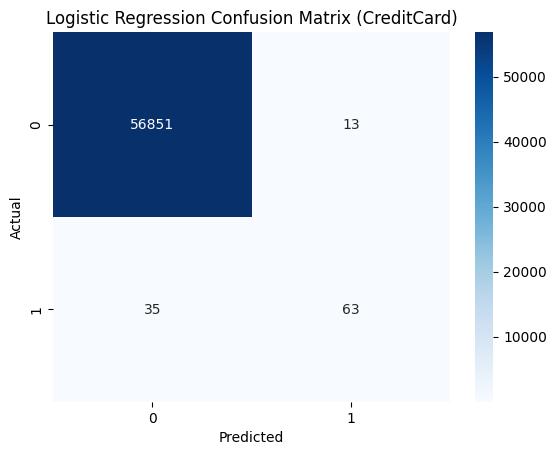


=== XGBoost on CreditCard ===
F1 Score: 0.8297872340425532
AUC-PR: 0.7972843396791324
Confusion Matrix:
 [[56852    12]
 [   20    78]]


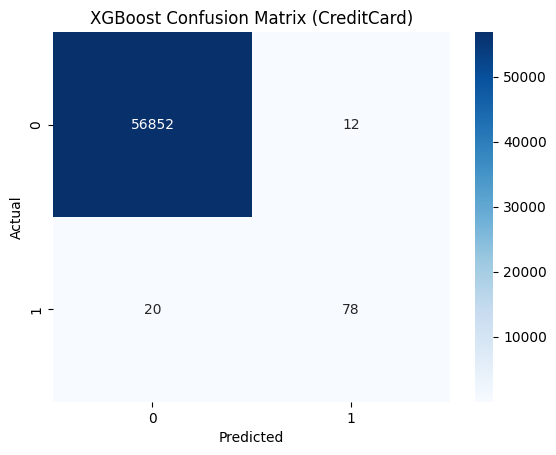


=== Logistic Regression on Fraud_Data ===
F1 Score: 0.6562782294489612
AUC-PR: 0.6635886824578401
Confusion Matrix:
 [[27248   145]
 [ 1377  1453]]


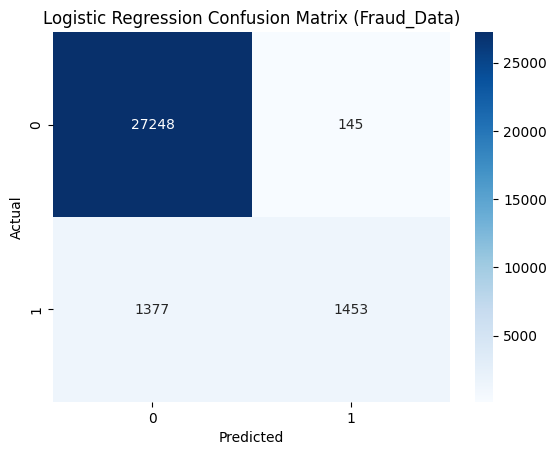


=== XGBoost on Fraud_Data ===
F1 Score: 0.6868826096944636
AUC-PR: 0.7038523768071334
Confusion Matrix:
 [[27365    28]
 [ 1335  1495]]


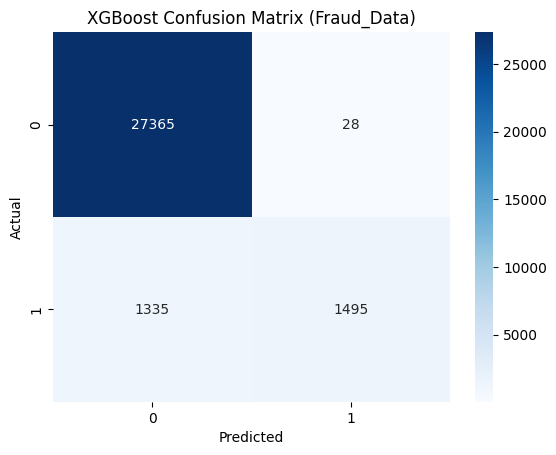

['models/xgb_fraud.pkl']

In [21]:
# ========================
# 8. EVALUATION & SAVE
# ========================
evaluate(y1_test, y1_pred_lr, y1_proba_lr, "Logistic Regression", "CreditCard")
joblib.dump(log_reg_credit, "models/logistic_creditcard.pkl")

evaluate(y1_test, y1_pred_xgb, y1_proba_xgb, "XGBoost", "CreditCard")
joblib.dump(xgb_credit, "models/xgb_creditcard.pkl")

evaluate(y2_test, y2_pred_lr, y2_proba_lr, "Logistic Regression", "Fraud_Data")
joblib.dump(log_reg_fraud, "models/logistic_fraud.pkl")

evaluate(y2_test, y2_pred_xgb, y2_proba_xgb, "XGBoost", "Fraud_Data")
joblib.dump(xgb_fraud, "models/xgb_fraud.pkl")

In [22]:
# ========================
# 10. SAVE ARTIFACTS (DATASETS, METRICS)
# ========================

import os
import json
from sklearn.metrics import f1_score, precision_recall_curve, auc

# Create folders
os.makedirs("artifacts", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Save preprocessed datasets
joblib.dump((X1_train, X1_test, y1_train, y1_test), "artifacts/creditcard_split.pkl")
joblib.dump((X2_train, X2_test, y2_train, y2_test), "artifacts/fraud_split.pkl")


# Compute metrics
precision1_lr, recall1_lr, _ = precision_recall_curve(y1_test, y1_proba_lr)
precision1_xgb, recall1_xgb, _ = precision_recall_curve(y1_test, y1_proba_xgb)
precision2_lr, recall2_lr, _ = precision_recall_curve(y2_test, y2_proba_lr)
precision2_xgb, recall2_xgb, _ = precision_recall_curve(y2_test, y2_proba_xgb)

results = {
    "creditcard": {
        "logistic": {
            "f1": f1_score(y1_test, y1_pred_lr),
            "auc_pr": auc(recall1_lr, precision1_lr)
        },
        "xgb": {
            "f1": f1_score(y1_test, y1_pred_xgb),
            "auc_pr": auc(recall1_xgb, precision1_xgb)
        }
    },
    "fraud_data": {
        "logistic": {
            "f1": f1_score(y2_test, y2_pred_lr),
            "auc_pr": auc(recall2_lr, precision2_lr)
        },
        "xgb": {
            "f1": f1_score(y2_test, y2_pred_xgb),
            "auc_pr": auc(recall2_xgb, precision2_xgb)
        }
    }
}

# Save evaluation metrics
with open("results/model_evaluation.json", "w") as f:
    json.dump(results, f, indent=2)

print("Datasets, and metrics saved successfully.")


Datasets, and metrics saved successfully.
